In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from pydpc import Cluster
%matplotlib inline
import scipy.io 

In [2]:
class lib_data(object):
    
    def size_rank(self):
        self.lib_size = np.sum(self.lib_counts,axis=1) #calculate 
        self.lib_rank = np.argsort(self.lib_size)[::-1]
        self.mt_mouse_mask = pd.Series( self.lib_counts.columns).str.contains('mt-').values # startswith() is case sensitive
        self.mt_human_mask = pd.Series( self.lib_counts.columns).str.contains('MT-').values # startswith() is case sensitive
        self.lib_rank_inflec = None 
        
    def __init__(self,hdf5_file = None,lib_counts = None):
        self.hdf5 = hdf5_file
        self.lib_counts = lib_counts #main array of count data
        if (hdf5_file == None):
            self.size_rank()

    def hdf5_to_counts(self):
        #need to put some kind of checker here to make sure that first index of datasets is actually counts and not vice versa 
        self.lib_counts=pd.DataFrame(self.hdf5['Top_Counts'].value)
        transcriptsIn=pd.DataFrame(self.hdf5['Transcripts'].value)
        barcodesIn=pd.DataFrame(self.hdf5['Barcodes'].value)
        transcriptsIn=list(transcriptsIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        barcodesIn=list(barcodesIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        self.lib_counts.columns=transcriptsIn
        self.lib_counts.index=barcodesIn
        self.size_rank()
        
    def marker_percent(self,mask):
        marker_sum = np.sum( self.lib_counts.iloc[:,mask].values, axis=1)
        return marker_sum/self.lib_size.astype(float)*100 #percent of counts that are mitochondrial given all counts in cell
           
    def find_inflection(self):
        
        cumsum=np.cumsum(self.lib_size)
        length=len(cumsum)
        x_vals=np.arange(0,length)
        secant_coef=cumsum[length-1]/length
        secant_line=secant_coef*x_vals
        secant_dist=abs(cumsum-secant_line)
        max_dist=np.where(np.max(secant_dist)==secant_dist)[0][0]
        plt.figure(figsize=(20,10))
        plt.plot(np.array(cumsum), label="Cumulative Sum")
        plt.plot(np.array(secant_line), label="Secant Line")
        plt.plot(np.array(secant_dist), label="CS-SL Distance")
        plt.axvline(x=max_dist,c='red',linestyle='--',linewidth=1,label="Inflection Point")
        plt.legend()
        self.lib_rank_inflec = np.sort(np.where(self.lib_rank<max_dist)).ravel()
        print("Inflection point at {}".format(max_dist))
        
    def top_n_lib_counts(self,inflec):
        top_n_output = self.lib_counts.iloc[inflec,:]
        return top_n_output

In [3]:
class dimension_reduction(object):
    
    def __init__(self,lib_data_in,seed = 42):
        self.lib_data = lib_data_in.lib_counts
        self.lib_size = lib_data_in.lib_size
        self.lib_rank = lib_data_in.lib_rank
        self.seed = seed
        np.random.seed(self.seed)

    def normalize_arcsinh(self,cofactor):
        self.lib_data = np.arcsinh(self.lib_data.div(self.lib_size.values,axis = 'rows')*cofactor)
        
    def runPCA(self,n_pcs):
        _pca = PCA(n_components = n_pcs)
        self.PCA = _pca.fit(self.lib_data).transform(self.lib_data)
    
    def runUMAP(self,n_neighbors = 10,min_dist = 0.5):
        self.UMAP = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, metric = 'correlation').fit_transform(self.PCA)

In [4]:
class gate_thresh(object):
    
    def __init__(self,dr_in):
        self.PCA = dr_in.PCA
        self.UMAP = dr_in.UMAP
        self.seed = dr_in.seed
        self.lib_rank = dr_in.lib_rank
        self.DPC = None
        
    def plotPCA(self):
        fig = plt.figure(figsize=(16,16))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)

        ax1.scatter(self.PCA[:,0],self.PCA[:,1],alpha=0.5, s=20)
        ax2.scatter(self.PCA[:,1],self.PCA[:,2],alpha=0.5, s=20)
        ax3.scatter(self.PCA[:,2],self.PCA[:,3],alpha=0.5, s=20)
        ax4.scatter(self.PCA[:,3],self.PCA[:,4],alpha=0.5, s=20)

        ax1.set_xlabel( "PC_0")
        ax1.set_ylabel( "PC_1")
        ax2.set_xlabel( "PC_1")
        ax2.set_ylabel( "PC_2")
        ax3.set_xlabel( "PC_2")
        ax3.set_ylabel( "PC_3")
        ax4.set_xlabel( "PC_3")
        ax4.set_ylabel( "PC_4")
    
    def plotUMAP(self,marker_overlay):
        cmap_rank = plt.cm.get_cmap('seismic_r')
        cmap_marker = plt.cm.get_cmap('viridis')
        cmap_clust=plt.cm.get_cmap('tab20', len(self.DPC.clusters))

        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        rank = ax1.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = self.lib_rank,cmap = cmap_rank)
        mito = ax2.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = marker_overlay,cmap = cmap_marker)
        clust = ax3.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = self.DPC.membership,cmap = cmap_clust) 
        
        plt.colorbar(rank, ax = ax1)
        plt.colorbar(mito, ax = ax2)
        plt.colorbar(clust, ax = ax3,ticks=range(len(self.DPC.clusters)))
        
        ax1.set_xlabel("Ranking")
        ax2.set_xlabel("Marker Enrichment")
        ax3.set_xlabel("Density Peak Clustering")
    
    def runDPC(self,dr,x_cutoff,y_cutoff,force_rerun = False):
        if ((self.DPC == None) or (force_rerun == True)):
            self.DPC = Cluster(dr.astype('float64'))
        self.DPC.assign(x_cutoff,y_cutoff)
        
    def manual_gating(self,gate_out):
        clust_inds = np.delete(np.arange(0,len(self.DPC.membership),1),gate_out) # clusters that represent cells to keep
        clust_mask = np.isin(self.DPC.membership, clust_inds)
        gated_embedding = self.UMAP[clust_mask]
        gated_ranking = self.lib_rank[clust_mask]

        cmap_rank = plt.cm.get_cmap('seismic_r')
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(111)
        rank = ax1.scatter(gated_embedding[:,0],gated_embedding[:,1],alpha=1,s=20,c = gated_ranking,cmap = cmap_rank)
        plt.colorbar(rank, ax = ax1)
        
        ax1.set_xlabel("Gated Ranking")
        
        return (clust_mask)

## Reading data from .hdf5 file

In [5]:
dataIn=h5py.File("Indrops-Gosline-Top-15k.hdf5","r")

In [6]:
list(dataIn.keys())

['Barcodes', 'Top_Counts', 'Transcripts']

## Initializing QC object from HDF5

In [7]:
indrops_data=lib_data(hdf5_file=dataIn)

In [8]:
indrops_data.hdf5_to_counts()

In [9]:
indrops_data.lib_counts.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
TATCTGTCGGGAACGA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
ACAAGTAGGTTGCACG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGCAACGCCATCTCCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TAGTCTCTAGCTATGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCTATGGGCCCTAACC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Perform inflection point thresholding, the current inflection point finding method assumes that the libraries have been sorted by size, or the number of counts per cell.

Inflection point at 11933


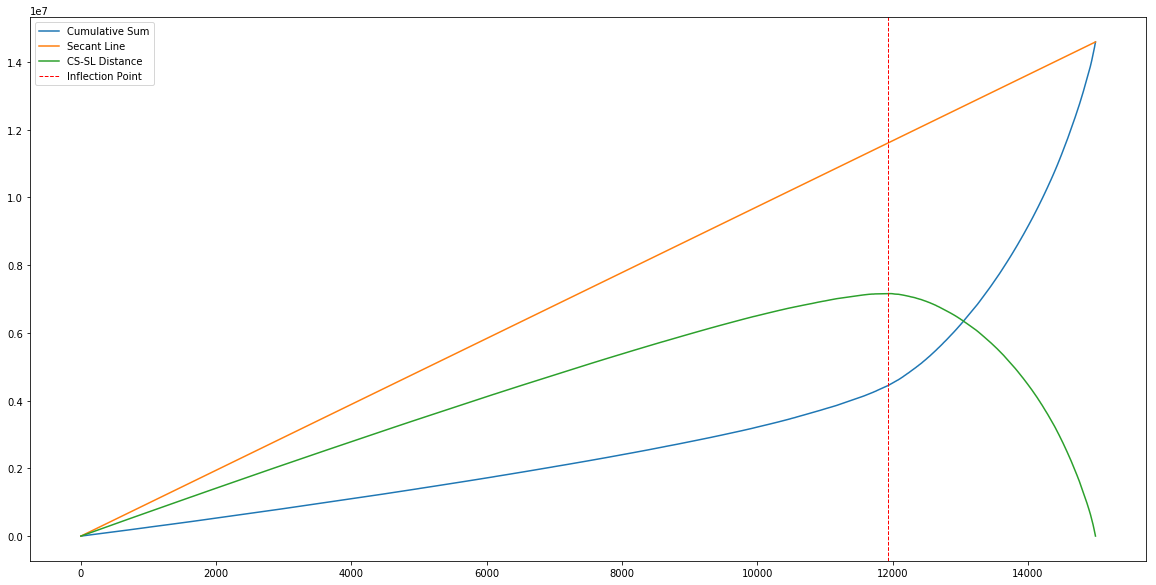

In [10]:
indrops_data.find_inflection()

In [11]:
lib_size_before_processing=indrops_data.lib_size

## Initialize new QC object with only the top libraries based on inflection point

In [12]:
indrops_data=lib_data(lib_counts=indrops_data.lib_counts.tail(len(indrops_data.lib_rank)-11933))

In [13]:
indrops_data.lib_counts.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
GTCTGGAAGTGTAACC,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CATTCGGGTAAGACGG,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACTAATTGCCCTTCAG,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
CACAACCTAGGCAGTT,0,0,0,0,1,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAGCCCGTTATCTGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
#normalization/transformation and dimensionality reduction 

## Initialize Dimension Reduction object for further analysis

In [15]:
indrops_dr=dimension_reduction(indrops_data)

In [16]:
indrops_dr.normalize_arcsinh(1000)

In [17]:
indrops_dr.runPCA(100)

In [18]:
indrops_dr.runUMAP()

In [19]:
indrops_gt=gate_thresh(indrops_dr)

In [20]:
human_mt_pct=indrops_data.marker_percent(indrops_data.mt_human_mask)
mouse_mt_pct=indrops_data.marker_percent(indrops_data.mt_mouse_mask)

## Run density based clustering, a method published by Rodriguez et al. Other clustering methods should also work as the resulting clusters are mostly to define groups of cells to gate out, but we've found DPC to be fast and intuitive to use. It also picks up non-spherical clusters like DBSCAN

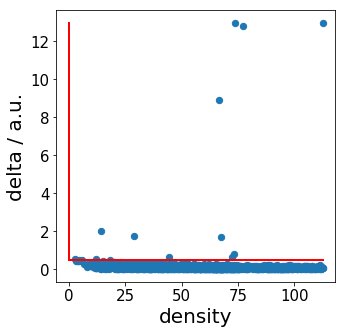

In [41]:
indrops_gt.runDPC(indrops_gt.UMAP,0.0,0.5)

In [22]:
indrops_dr.lib_data.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
GTCTGGAAGTGTAACC,0.0,0.0,0.0,0.0,0.00000,1.018128,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATTCGGGTAAGACGG,0.0,0.0,0.0,0.0,0.00000,2.181744,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACTAATTGCCCTTCAG,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,1.122556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CACAACCTAGGCAGTT,0.0,0.0,0.0,0.0,0.69874,2.617326,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGCCCGTTATCTGT,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualize ordinal library quality, marker or defined metagene enrichment, and density peak cluster identification

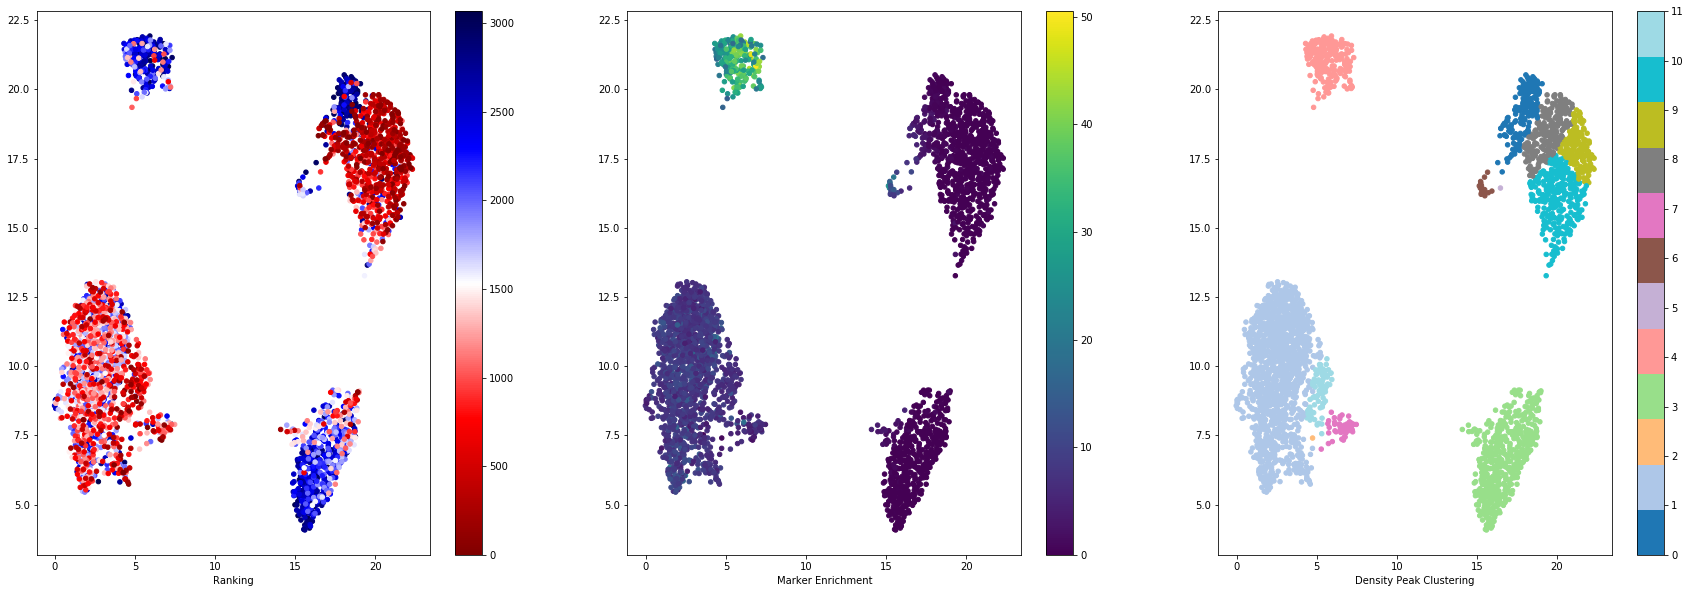

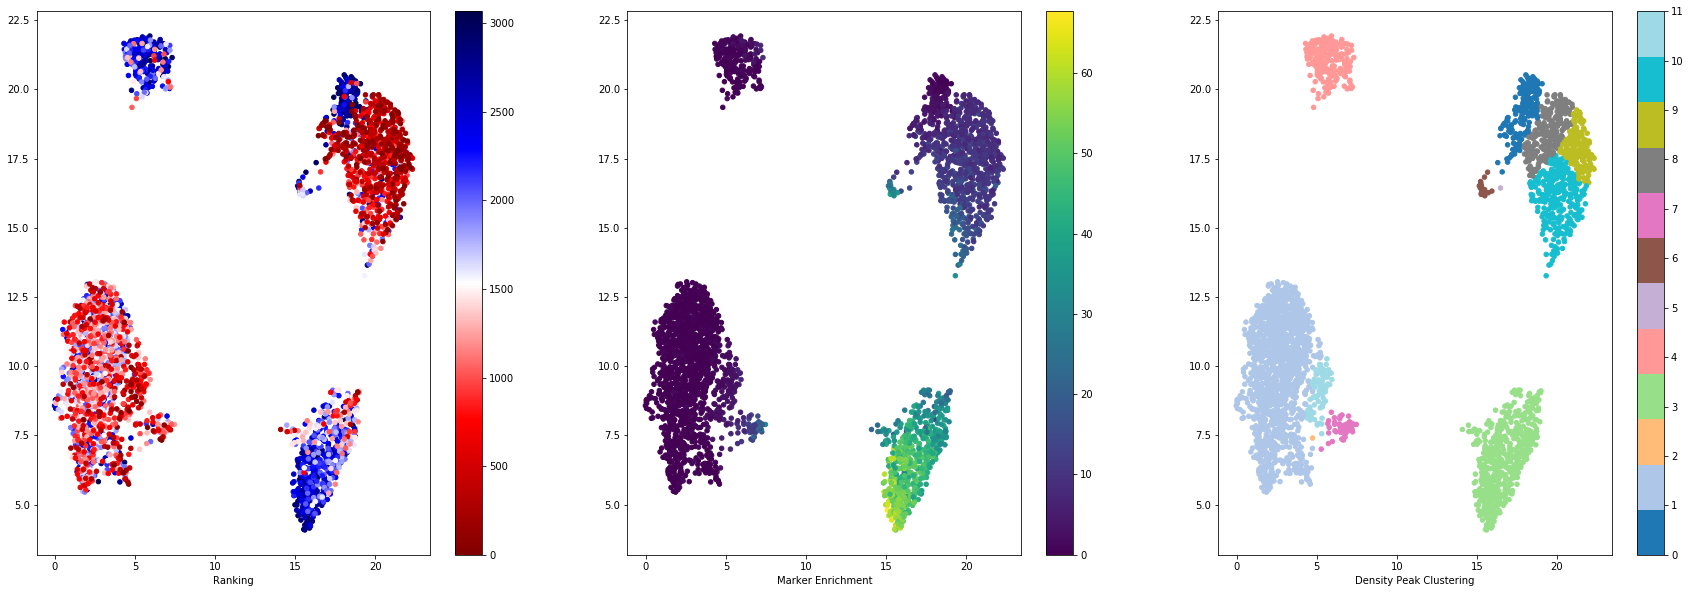

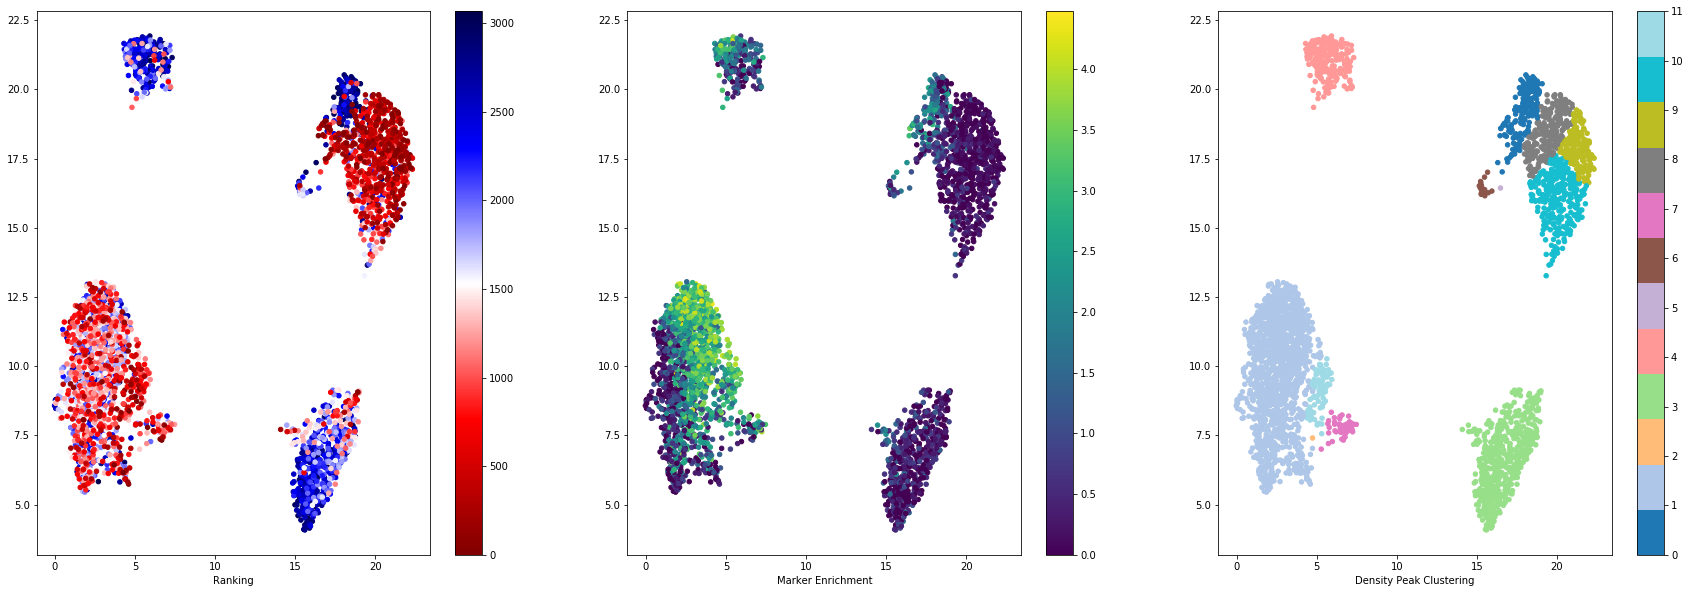

In [23]:
indrops_gt.plotUMAP(mouse_mt_pct)
indrops_gt.plotUMAP(human_mt_pct)
indrops_gt.plotUMAP(indrops_dr.lib_data['mm10_Igf2'])

## Gate out low quality or dead cells as defined by library size and aggregate mitochondrial markers 

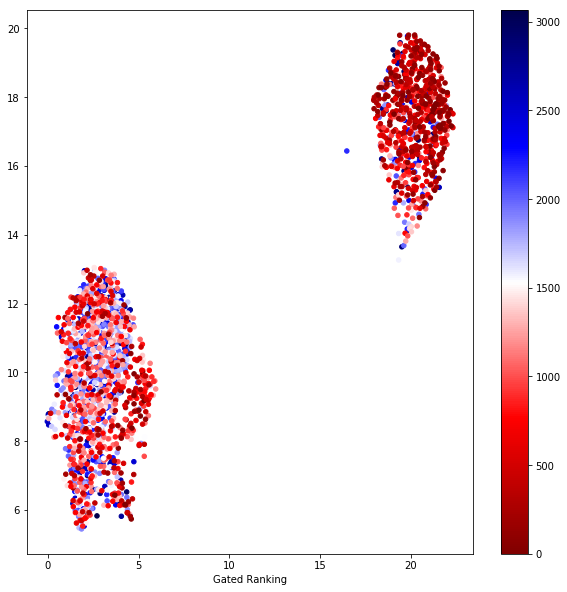

In [24]:
gated_indices=indrops_gt.manual_gating([4,3,0,6,7])

In [25]:
gated_indrops_data=lib_data(lib_counts=indrops_data.lib_counts[gated_indices]) #make new gated object

In [26]:
mouse_gene_mask=pd.Series(gated_indrops_data.lib_counts.columns.str.contains("mm10_")).values
human_gene_mask=pd.Series(gated_indrops_data.lib_counts.columns.str.contains("hg19_")).values

In [27]:
human_pct_gated=gated_indrops_data.marker_percent(human_gene_mask)
mouse_pct_gated=gated_indrops_data.marker_percent(mouse_gene_mask)

## Re-run dimensionality reduction as we have now removed cells that may have affected the global structure of the data

In [28]:
gated_indrops_dr=dimension_reduction(gated_indrops_data)

In [29]:
gated_indrops_dr.normalize_arcsinh(1000)

In [30]:
gated_indrops_dr.runPCA(100)

In [31]:
gated_indrops_dr.runUMAP()

/Users/bob/anaconda3/envs/srsAnalysis/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [32]:
gated_indrops_gt=gate_thresh(gated_indrops_dr)

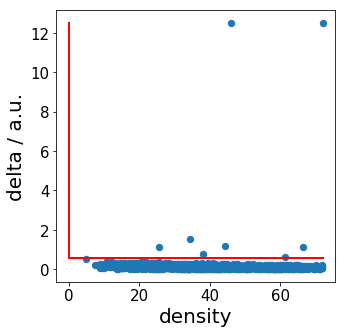

In [42]:
gated_indrops_gt.runDPC(gated_indrops_gt.UMAP,0.0,0.55)

## Visualize ordinal library quality, marker or defined metagene enrichment, and density peak cluster identification

## Overlays represent aggregates of all human or all mouse genes 

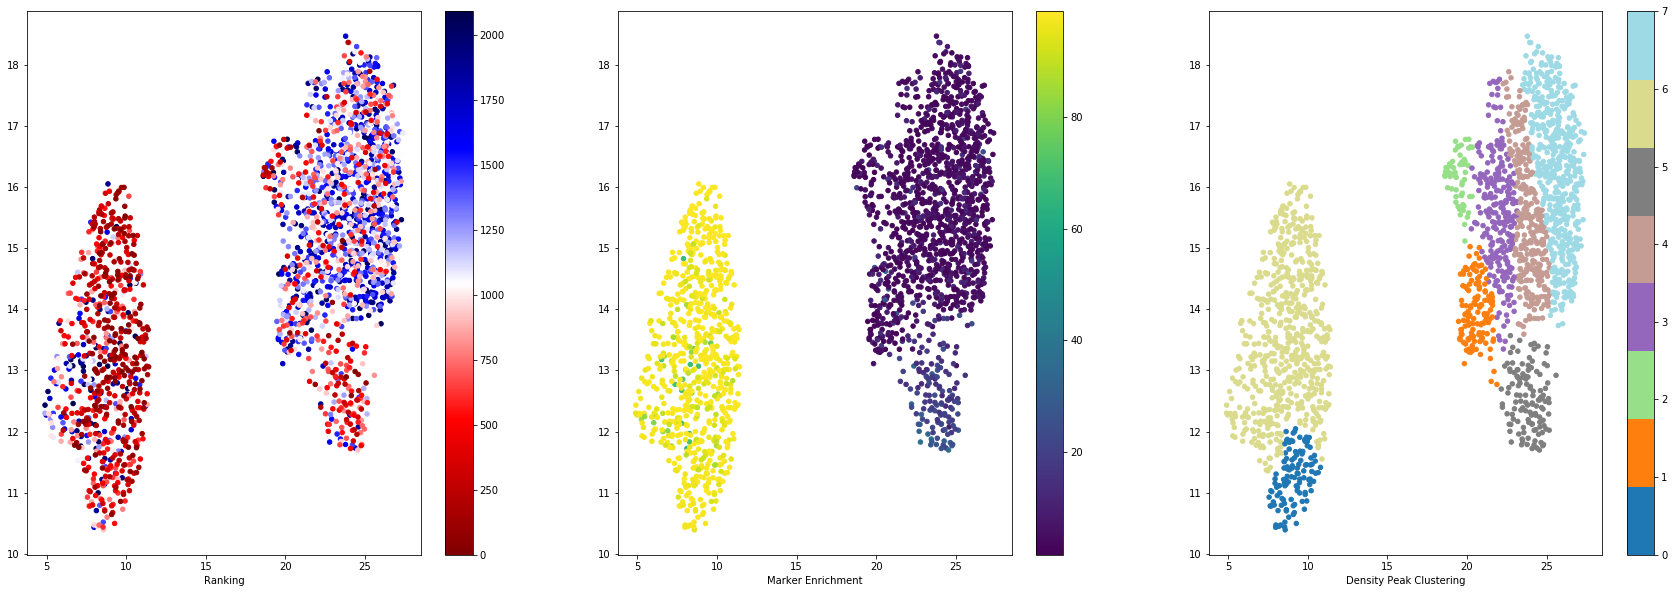

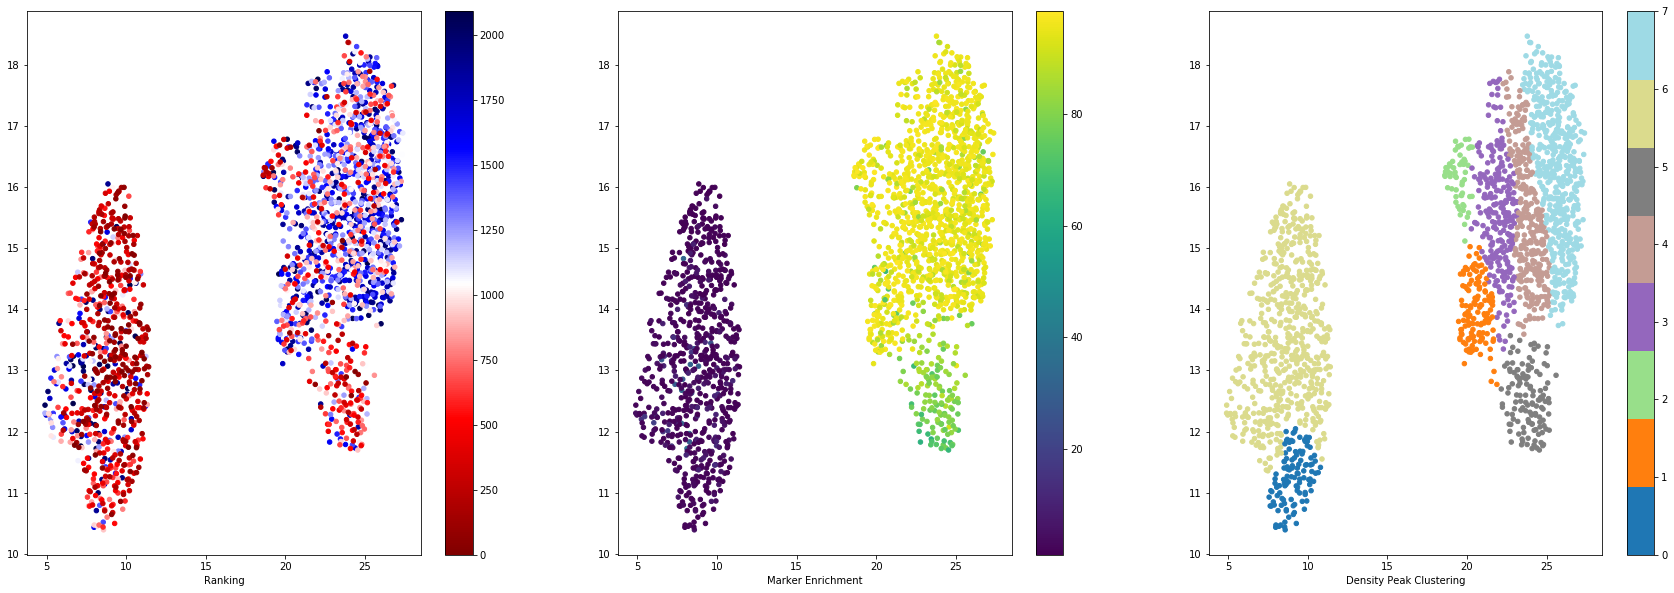

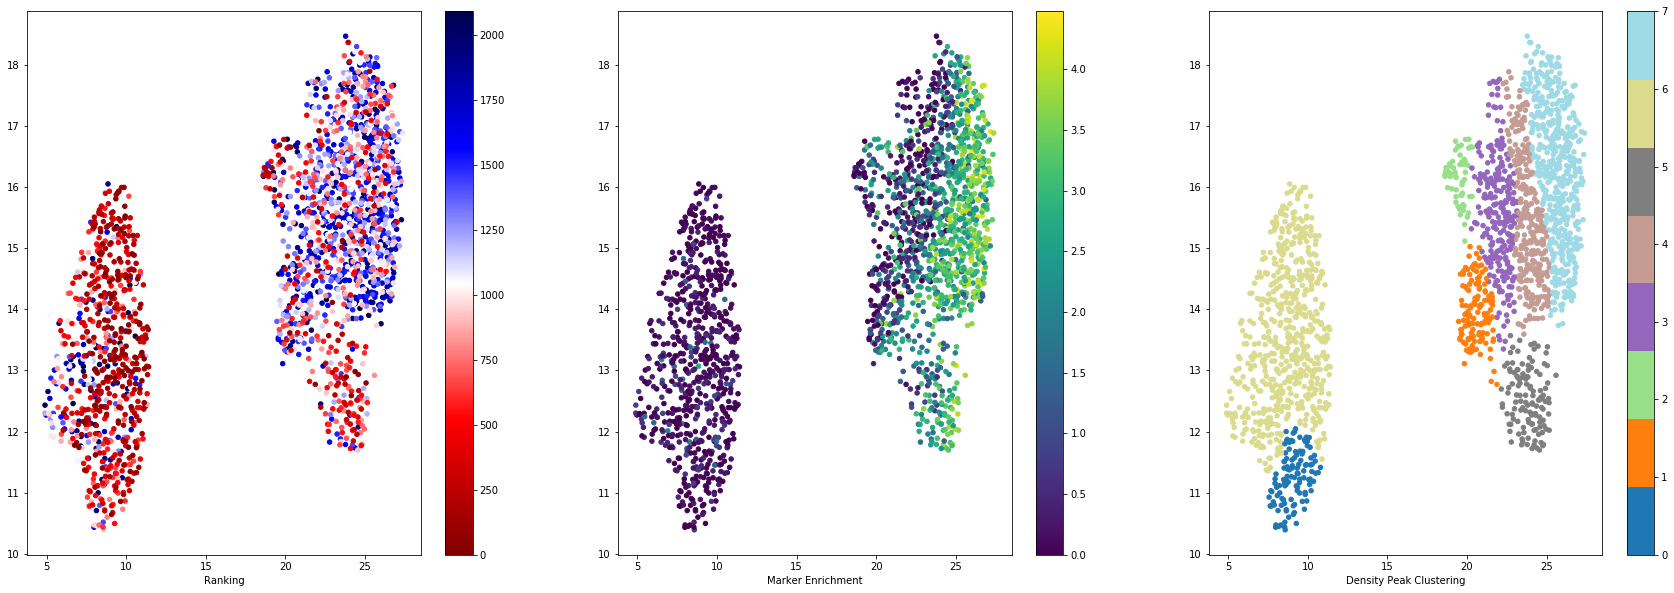

In [34]:
gated_indrops_gt.plotUMAP(human_pct_gated)
gated_indrops_gt.plotUMAP(mouse_pct_gated)
gated_indrops_gt.plotUMAP(gated_indrops_dr.lib_data['mm10_Igf2'])

## Calculate general statistics and visualize library quality by size and its progression at each step of processing

Text(0.5, 0, 'Number of UMIs')

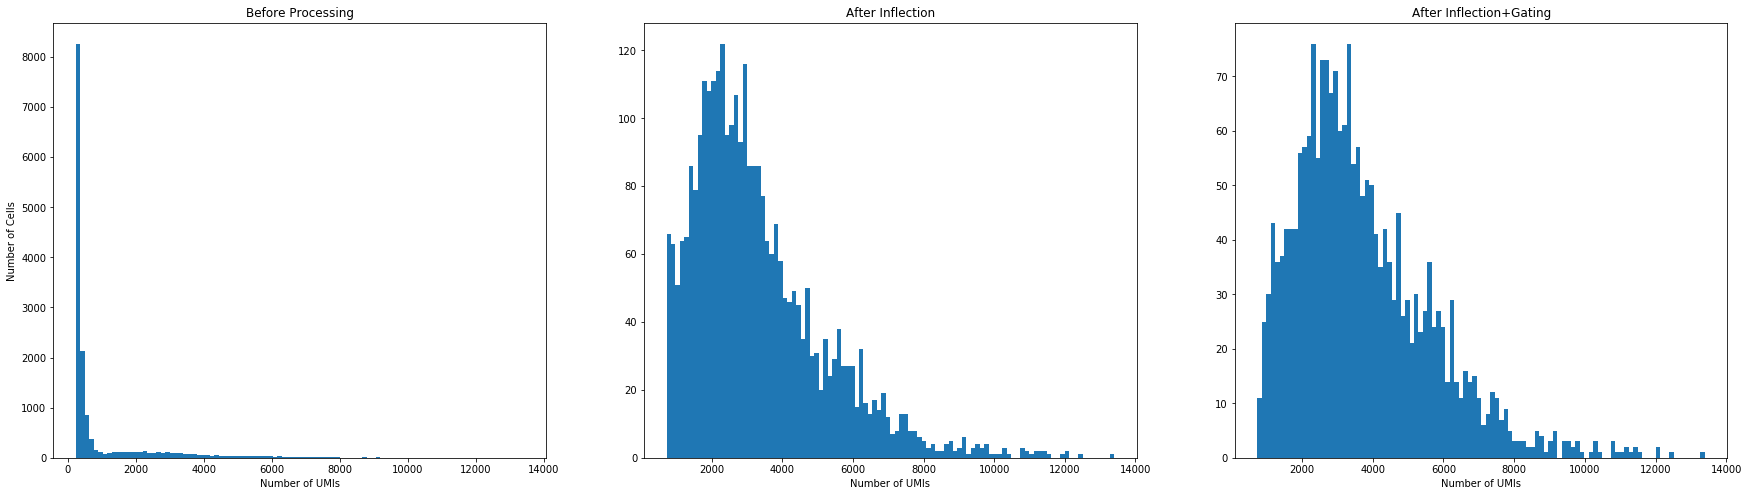

In [40]:
fig = plt.figure(figsize=(30,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.hist(lib_size_before_processing,bins=100)
ax2.hist(indrops_data.lib_size,bins=100)
ax3.hist(gated_indrops_data.lib_size,bins=100)

ax1.set_title("Before Processing")
ax1.set_ylabel("Number of Cells")
ax1.set_xlabel("Number of UMIs")
ax2.set_title("After Inflection")
ax2.set_xlabel("Number of UMIs")
ax3.set_title("After Inflection+Gating")
ax3.set_xlabel("Number of UMIs")

In [36]:
summary=pd.DataFrame([gated_indrops_data.lib_size.describe(),indrops_data.lib_size.describe(),lib_size_before_processing.describe()])

In [37]:
summary.index=['UMIs After_Inflection+Gating','UMIs After_Inflection','UMIs Before_Processing']
summary

,count,mean,std,min,25%,50%,75%,max
UMIs After_Inflection+Gating,2092.0,3715.966061,1927.953984,737.0,2320.75,3317.5,4759.00,13398.0
UMIs After_Inflection,3067.0,3308.975546,1885.753208,722.0,1965.50,2879.0,4183.50,13398.0
UMIs Before_Processing,15000.0,972.969667,1467.026063,238.0,290.00,348.0,628.25,13398.0
